Imports 

In [1]:
!pip install catboost -q
!pip install optuna -q

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import KFold,train_test_split
import os 
import gc

#catboost
from catboost import Pool, CatBoostRegressor

#optimization 
import optuna 
from optuna import Trial as trial
#metrics 
from sklearn.metrics import r2_score,mean_squared_error

from pathlib import Path

pd.set_option('display.max_columns',None)

In [2]:


class config:
    def __init__(self,seed):
        self.seed = seed
        
                
#cfg 
cfg = config(seed=7)



**Loading Data**

In [3]:
DATA_PATH = Path.cwd().parent / "data"

processed= DATA_PATH / "processed"

In [4]:
train = pd.read_csv(processed / "train.csv")
test = pd.read_csv(processed / "test.csv")

test_ids = pd.read_csv(processed / "test_ids.csv")

sample_sub = pd.read_csv(DATA_PATH / "raw/submission_format.csv")

In [5]:
train.head()

,no2,trop_no2,trop_no2_cs,col_no2,col_no2_cs,null_fields,Delhi,Los Angeles (SoCAB),year,cos_month,sin_month
0,8.695000,4.481723,4.481723,6.237321,6.237321,0,0,1,1,0.866025,0.5
1,10.496667,5.436216,5.436216,7.206068,7.206068,0,0,1,1,0.866025,0.5
2,37.208333,6.966879,6.966879,8.714388,8.714388,0,0,1,1,0.866025,0.5
3,9.791667,6.361926,6.361926,8.107447,8.107447,0,0,1,1,0.866025,0.5
4,4.308333,2.464319,2.464319,4.228561,4.228561,0,0,1,1,0.866025,0.5


In [6]:
y = train.pop("no2")
X = train

X_test = test

assert len(set(X)-set(X_test)) == 0 ,"if it keeps on raining, I am gonna break."

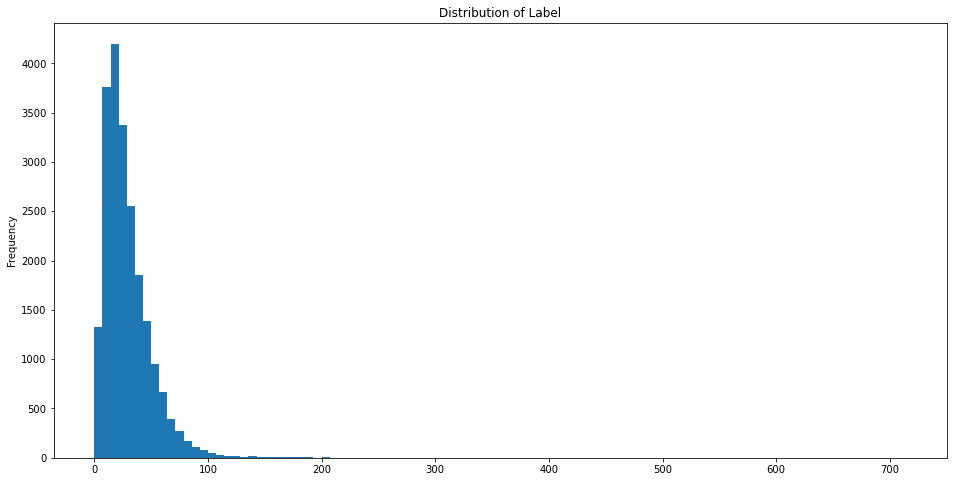

In [7]:
y.plot(kind='hist',figsize=(16,8),bins=100,title='Distribution of Label')
plt.show()

In [8]:

def split_data(X,y,test_size=0.1):
    '''split data into train and test set'''
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size= test_size)
    
    for df in [x_train,x_test,y_train,y_test]:  # reset index
        df.reset_index(drop=True,inplace=True)
    
    return x_train,x_test,y_train,y_test



x_train,x_val,y_train,y_val = split_data(X=train,
                                         y=y,
                                         test_size=0.1)

print(f' training shape {x_train.shape} \n test shape {x_val.shape}')



 training shape (19188, 10) 
 test shape (2132, 10)


Optuna hyperparamtuning

In [9]:
class catboost_optimization:
    def __init__(self,
                 X,
                 y,
                 params=None,
                 categorical = None,
                 seed=cfg.seed):
        self.params = params
        self.seed   = seed
        self.categorical = categorical
        self.X = X
        self.y = y
        

    def objective(self,
                  trial:optuna.Trial):
        
        
        
        self.params = {
                'verbose'        : 1,
               'loss_function'  :'RMSE',
               'depth'          :trial.suggest_int('depth',4,10),
               'learning_rate'  :trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
               'l2_leaf_reg'    :trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
               'random_strength':trial.suggest_uniform('random_strength',1e-2,0.5),
               'max_bin'        :trial.suggest_int('max_bin',64,254),
               'grow_policy'    :trial.suggest_categorical('grow_policy',
                                                           ['SymmetricTree','Depthwise']),
               'iterations'     :trial.suggest_int('iterations',1000,2000),
#                'max_leaves'     :trial.suggest_int('max_leaves',2,64),
               "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.7),
#                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
               "bootstrap_type": trial.suggest_categorical("bootstrap_type",
                                                           ["Bayesian", "MVS",'Bernoulli']),
               'eval_metric': 'R2'
                }

        #splitting training data 
        x_tr,x_ts,y_tr,y_ts=train_test_split(self.X,
                                             self.y,
                                             random_state=self.seed,
                                             train_size=0.60)
        
# `
        try:
            model = CatBoostRegressor(**self.params)
            
            model.fit(x_tr,y_tr,
                     eval_set=[(x_ts,y_ts)],
                     verbose=0,
                     cat_features=self.categorical,
                     early_stopping_rounds=300)
  

            preds=model.predict(x_ts)

            acc= mean_squared_error(y_ts,preds)
            del x_tr,x_ts,y_tr,y_ts;gc.collect()
            return acc

        except Exception as e:
            print(e)
            return None
   
    def get_best_params(self,
                        n_trials = 30,
                        time_out=9000,
                        direction= 'minimize'):
        
        print(f'Running optimization for {time_out} seconds / {n_trials} Trials')
        
        
        sampler = optuna.samplers.TPESampler(seed=self.seed)  # Make the sampler behave in a deterministic way.

        self.study=optuna.create_study(direction=direction,
                                        sampler=sampler)
        self.study.optimize(self.objective,
                           n_trials=n_trials,
                           timeout=time_out)

        print("Number of finished trials: {}".format(len(self.study.trials)))

        return self.study.best_trial.params

    def plot_history(self):
        '''plot optimization history :
        credits : https://medium.com/databulls/tps-mar21-leaderboard-14-xgb-catboost-lgbm-optuna-cdffb5124368'''
        optuna.visualization.plot_optimization_history(self.study)
        
    def plot_param_importances(self):
        '''plot param imp'''
        optuna.visualization.plot_param_importances(self.study)

In [ ]:


catb_optimizer = catboost_optimization(X=x_train,
                                       y=y_train,
                                      )


best_params = catb_optimizer.get_best_params(n_trials = 20,
                                            time_out=1000,
                                            direction= 'minimize')  # run hyperparam optimization



[I 2022-03-21 20:51:32,463] A new study created in memory with name: no-name-a3bdccd2-e421-4d53-9e24-4312a4dd24cc


Running optimization for 1000 seconds / 20 Trials


[I 2022-03-21 20:51:33,890] Trial 0 finished with value: 298.46590320407796 and parameters: {'depth': 4, 'learning_rate': 0.021865347140571728, 'l2_leaf_reg': 0.2066463288698664, 'random_strength': 0.3644979371371612, 'max_bin': 250, 'grow_policy': 'SymmetricTree', 'iterations': 1072, 'colsample_bylevel': 0.40737559204074847, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 298.46590320407796.


In [21]:
best_params={'depth': 5, 'learning_rate': 0.02865347140571728, 'l2_leaf_reg': 0.2066463288698664, 'random_strength': 0.3644979371371612, 'max_bin': 250, 'grow_policy': 'SymmetricTree', 'iterations': 1072, 'colsample_bylevel': 0.50737559204074847, 'bootstrap_type': 'MVS'}

In [22]:
best_params.update({'iterations':2500,
                    'verbose':0})

cfg.best_params = best_params

best_params

{'depth': 5,
 'learning_rate': 0.02865347140571728,
 'l2_leaf_reg': 0.2066463288698664,
 'random_strength': 0.3644979371371612,
 'max_bin': 250,
 'grow_policy': 'SymmetricTree',
 'iterations': 2500,
 'colsample_bylevel': 0.5073755920407484,
 'bootstrap_type': 'MVS',
 'verbose': 0}

In [23]:
class my_estimator:
    def __init__(self,
                 estimator):
        self.estimator_obj = estimator
        self.estimator_list = []
        
    def fit(self,
            X,
            y,
            params= {},
            categorical=None):
        
        '''fit X,y to the data'''
        
        self.params= params
        self.estimator = self.estimator_obj(**self.params)
        
        if categorical:
            self.estimator.fit(X,y,
                               cat_features = categorical)
        else:
            self.estimator.fit(X,y)
            
        return None
            
    def predict(self,X_test):
        '''predict using estimator'''
        
        if not self.estimator:
            print("Fit the model using 'model.fit(X,y)' first!")
            
        return self.estimator.predict(X_test)
    
    def fit_in_folds(self,
                     X,
                     y,
                     categorical=None,
                     params={},
                     eval_metric = mean_squared_error,
                     cv=KFold(n_splits=10)):
        '''fit multiple models using k-fold cross validation strategy'''
        
        self.params = params
           

        for train_idx,val_idx in cv.split(X,y):

            x_t,x_v=X.iloc[train_idx],X.iloc[val_idx]
            y_t,y_v=y.iloc[train_idx],y.iloc[val_idx]

            self.estimator=self.estimator_obj(**self.params)    


            if categorical:
                self.estimator.fit(x_t,y_t,
                                   cat_features = categorical)
            else:
                self.estimator.fit(x_t,y_t)

            n = 0 
            print('Validation score for fold {} is {}'.format(n,eval_metric(y_v,
                                                                           self.estimator.predict(x_v)
                                                                          )
                                                              )
                 )
            
            print(f'fitted on {n+1} folds')
            
            
            n+=1

            self.estimator_list.append(self.estimator) # store fitted models

            

        return None

    def predict_in_folds(self,
                         X_test):
        
        if len(self.estimator_list) <1:
            print("Fit the data on multiple folds by calling 'model.fit_in_folds(X,y)' ")
        else:
            predictions_list = []
            for model in self.estimator_list:
                pred = model.predict(X_test)
                
                predictions_list.append(pred)
                
            predictions = np.array(predictions_list).T  # (n,m) dim array, where n is number of examples and m is number of models
        
        
        return predictions
            
    def aggregate_predictions(self,
                              predictions,
                              agg='mean'):
        '''aggregate predictions'''
        
        
        if agg == 'mean':
            return predictions.mean(axis=1)
        elif agg == 'median':
            return np.median(a= predictions,
                             axis=1)
                   
        else:
            print("assign 'agg' to either of ['mean','median']")
            
            return None
            

In [ ]:
%%time

estimator = my_estimator(estimator=CatBoostRegressor)


estimator.fit_in_folds(X = x_train,y = y_train,
                      categorical=None,
                      params=cfg.best_params,
                      eval_metric = mean_squared_error,
                      cv=KFold(n_splits=10))

Validation score for fold 0 is 286.2400624274179
fitted on 1 folds
Validation score for fold 0 is 469.34984020462053
fitted on 1 folds
Validation score for fold 0 is 253.145930473861
fitted on 1 folds
Validation score for fold 0 is 275.83963380303715
fitted on 1 folds
Validation score for fold 0 is 297.2461613611982
fitted on 1 folds
Validation score for fold 0 is 315.91595356479
fitted on 1 folds
Validation score for fold 0 is 298.87676123697054
fitted on 1 folds
Validation score for fold 0 is 299.87870257220146
fitted on 1 folds


In [14]:
# prediction on validation data
predictions_val = estimator.predict_in_folds(X_test = x_val)


#get mean value of predictions
mean_pred_val = estimator.aggregate_predictions(predictions = predictions_val,
                                                agg='mean')
print(f'R2 score of mean value pred on test set is {r2_score(y_val,mean_pred_val)}')

#get median value of predictions
med_pred_val = estimator.aggregate_predictions(predictions = predictions_val,
                                                agg='median')
print(f'R2 score of median value pred on test set is {r2_score(y_val,med_pred_val)}')

R2 score of mean value pred on test set is 0.351571253847887
R2 score of median value pred on test set is 0.3529878157589246


In [16]:
#predict on test
test_pred = estimator.predict_in_folds(X_test = X_test)

mean_test = estimator.aggregate_predictions(predictions = test_pred,
                                                agg='mean')

med_test = estimator.aggregate_predictions(predictions = test_pred,
                                                agg='median')


In [31]:
test_pred_df = pd.DataFrame({'datetime':test_ids.datetime,
                             'grid_id' :test_ids.grid_id,
                             'value':med_test})

test_pred_df['day'] = pd.to_datetime(test_pred_df.datetime).dt.date

test_pred_df2 = pd.DataFrame({'datetime':test_ids.datetime,
                             'grid_id' :test_ids.grid_id,
                             'value':mean_test})

test_pred_df2['day'] = pd.to_datetime(test_pred_df2.datetime).dt.date


test_pred_df.shape

(15884, 4)

In [32]:
sample_sub.shape

(16350, 4)

In [33]:
sample_sub['day'] = pd.to_datetime(sample_sub.datetime).dt.date

sample_sub.head()

,datetime,grid_id,value,day
0,2018-09-08T08:00:00Z,3A3IE,0.0,2018-09-08
1,2018-09-08T08:00:00Z,3S31A,0.0,2018-09-08
2,2018-09-08T08:00:00Z,7II4T,0.0,2018-09-08
3,2018-09-08T08:00:00Z,8BOQH,0.0,2018-09-08
4,2018-09-08T08:00:00Z,A2FBI,0.0,2018-09-08


In [38]:
#mean of subs
sub_med = sample_sub[['datetime','grid_id','day']].merge(test_pred_df.drop('datetime',axis=1),
                                                         on = ['grid_id','day'],
                                                         how = 'left')

sub_med.drop('day',inplace=True,axis=1)
sub_med.shape

(16350, 3)

In [45]:
sub_med.head()

,datetime,grid_id,value
0,2018-09-08T08:00:00Z,3A3IE,19.342390
1,2018-09-08T08:00:00Z,3S31A,21.105229
2,2018-09-08T08:00:00Z,7II4T,24.960409
3,2018-09-08T08:00:00Z,8BOQH,19.072842
4,2018-09-08T08:00:00Z,A2FBI,25.396187


In [50]:
#filling null values with bfills and ffill

sub_med_filled=sub_med.bfill().ffill()

sub_med_filled.to_csv('median.csv',index=False)

mean of preds

In [47]:
#mean of subs
sub_med = sample_sub[['datetime','grid_id','day']].merge(test_pred_df2.drop('datetime',axis=1),
                                                         on = ['grid_id','day'],
                                                         how = 'left')

sub_med.drop('day',inplace=True,axis=1)
sub_med.shape

(16350, 3)

In [48]:
sub_med.head()

,datetime,grid_id,value
0,2018-09-08T08:00:00Z,3A3IE,19.120420
1,2018-09-08T08:00:00Z,3S31A,20.913107
2,2018-09-08T08:00:00Z,7II4T,24.780339
3,2018-09-08T08:00:00Z,8BOQH,19.126924
4,2018-09-08T08:00:00Z,A2FBI,25.428359


In [51]:
#filling null values with bfills and ffill

sub_med_filled=sub_med.bfill().ffill()

sub_med_filled.to_csv('mean.csv',index=False)